In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("/home/ec2-user/SageMaker/SignData/sign_mnist_train.csv")

In [5]:
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [6]:
data = data.sample(frac=1)
#Y = data.iloc[:,0].values.reshape((-1,1))
Y = data.iloc[:,0].values
X = data.iloc[:,1:].values.reshape((-1,28,28))

In [7]:
print(X.shape,"\t",Y.shape)

(27455, 28, 28) 	 (27455,)


In [8]:
X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [9]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(21964, 28, 28) (21964,) (5491, 28, 28) (5491,)


In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
#adding channel dimension
X_train = X_train[...,tf.newaxis].astype("float32")
X_test = X_test[...,tf.newaxis].astype("float32")

In [12]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(21964, 28, 28, 1) (21964,) (5491, 28, 28, 1) (5491,)


4


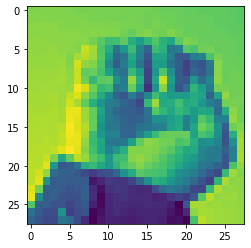

In [13]:
plt.imshow(X_train[0].reshape((28,28)))
print(Y_train[0])

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(10000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(10000).batch(256)

In [15]:
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [16]:
test_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [17]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import Model

In [18]:
class SignConvModel(Model):
    def __init__(self):
        super(SignConvModel,self).__init__()
        self.conv1 = Conv2D(32,3,activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(400,activation='relu')
        self.d2 = Dense(100,activation='relu')
        self.d3 = Dense(26)
        
    def call(self,x):
        a1 = self.conv1(x)
        a2 = self.flatten(a1)
        a3 = self.d1(a2)
        a4 = self.d2(a3)
        a5 = self.d3(a4)
        #a4 = tf.keras.activations.softmax(z4)
        #a4 = tf.nn.softmax(z4)
        return a1,a2,a3,a4,a5
        
model = SignConvModel()

In [19]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [20]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [21]:
@tf.function
def train_step(X,Y):
    with tf.GradientTape() as tape:
        a1,a2,a3,a4,yhat = model(X,training=True)
        #print(Y.shape,yhat.shape)
        loss = loss_function(Y,yhat)
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(Y,yhat)

In [22]:
@tf.function
def test_step(X,Y):
    a1,a2,a3,a4,yhat = model(X,training=False)
    loss = loss_function(Y,yhat)
    
    test_loss(loss)
    test_accuracy(Y,yhat)

In [23]:
epochs = 5

loss = []
accuracy = []
t_loss = []
t_accuracy = []

for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images,labels in train_dataset:
        train_step(images,labels)
    
    for images,labels in test_dataset:
        test_step(images,labels)
    
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    t_loss.append(train_loss.result())
    t_accuracy.append(train_accuracy.result())

    print(
        f"Epoch: {epoch+1}\n"
        f"\tTraining Loss: {loss[-1]}\n"
        f"\tTraining Accuracy: {accuracy[-1] * 100}\n"
        f"\tTest Loss: {t_loss[-1]}\n"
        f"\tTest Accuracy: {t_accuracy[-1] * 100}\n"
    )

Epoch: 1
	Training Loss: 2.3934099674224854
	Training Accuracy: 33.0358772277832
	Test Loss: 2.3934099674224854
	Test Accuracy: 33.0358772277832

Epoch: 2
	Training Loss: 0.921759307384491
	Training Accuracy: 74.94536590576172
	Test Loss: 0.921759307384491
	Test Accuracy: 74.94536590576172

Epoch: 3
	Training Loss: 0.4108748733997345
	Training Accuracy: 90.77581787109375
	Test Loss: 0.4108748733997345
	Test Accuracy: 90.77581787109375

Epoch: 4
	Training Loss: 0.1745108962059021
	Training Accuracy: 97.50501251220703
	Test Loss: 0.1745108962059021
	Test Accuracy: 97.50501251220703

Epoch: 5
	Training Loss: 0.07958295941352844
	Training Accuracy: 99.55381774902344
	Test Loss: 0.07958295941352844
	Test Accuracy: 99.55381774902344



In [28]:
testing_y = model(X_test[0][tf.newaxis,...])

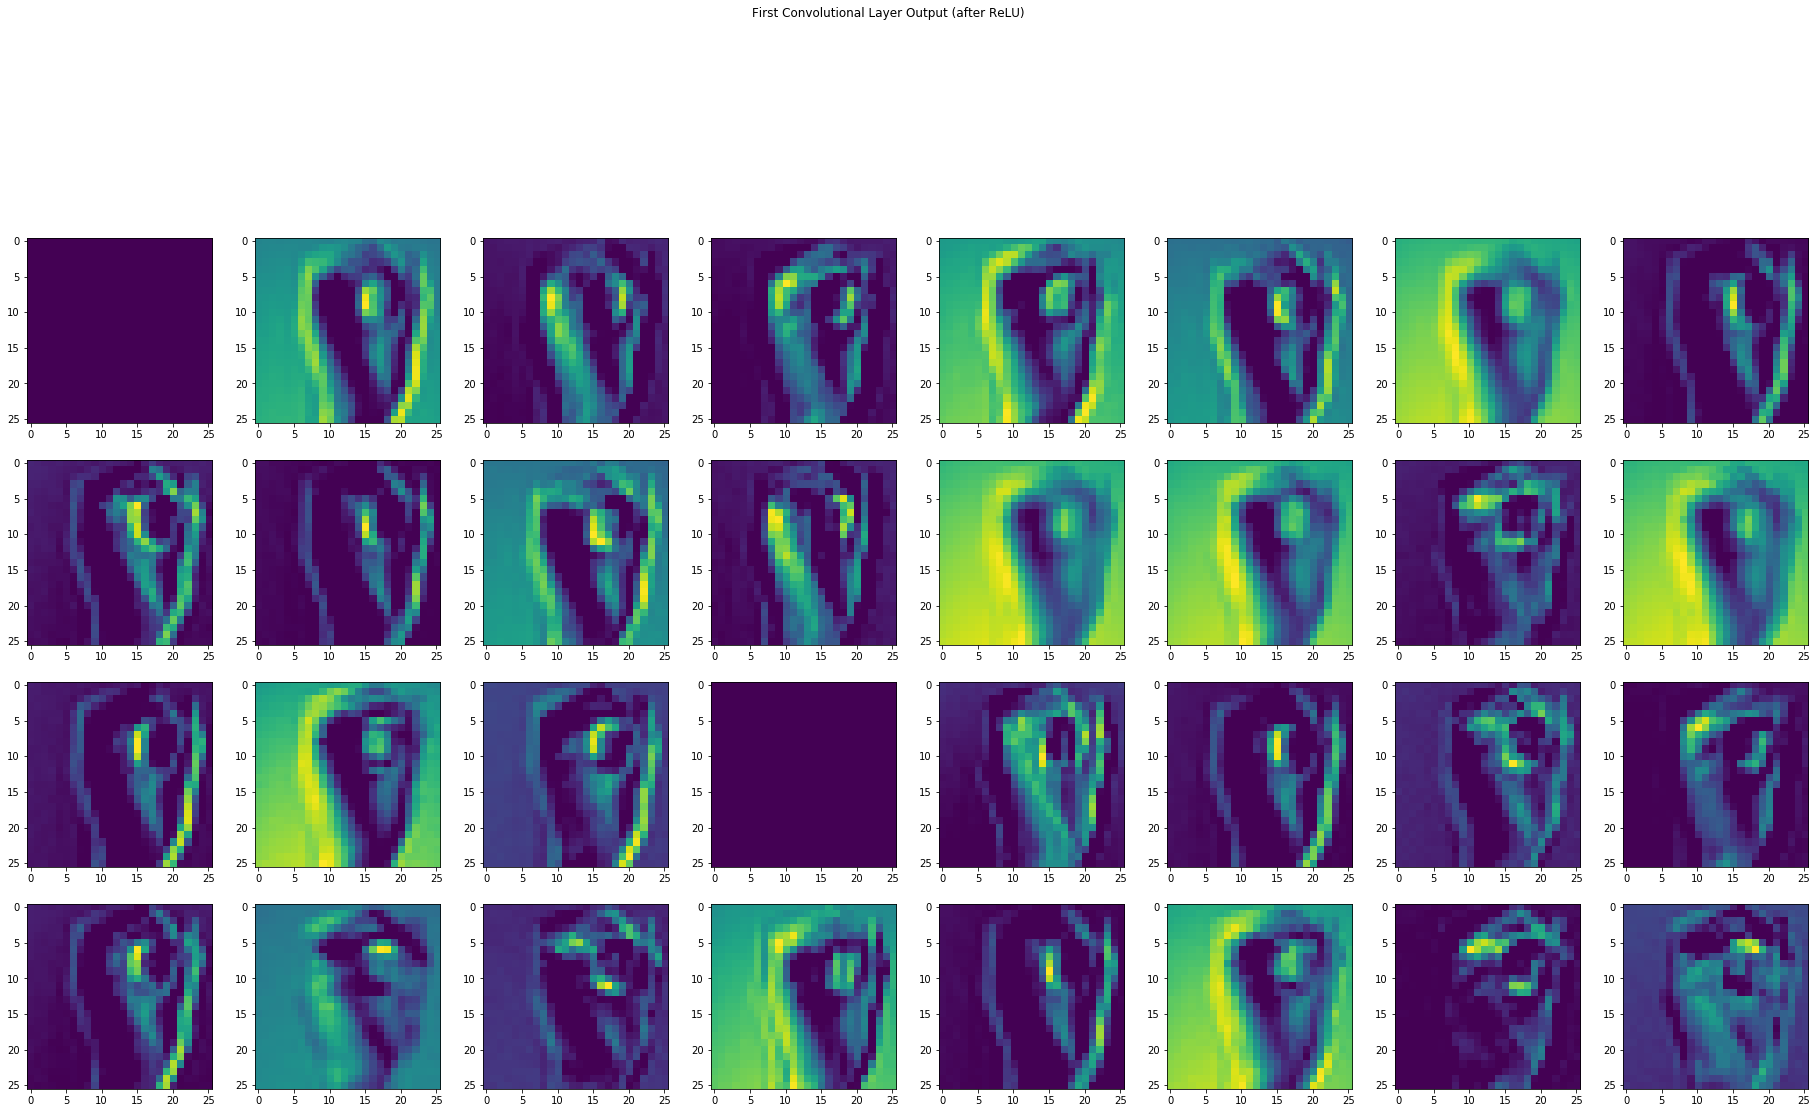

In [29]:
channels = testing_y[0].numpy().shape[3]
plt.figure(figsize=(channels,channels))
plt.suptitle("First Convolutional Layer Output (after ReLU)")
for i in range(channels):
    plt.subplot(channels/4,channels/4,(i+1))
    plt.imshow(testing_y[0].numpy().squeeze()[:,:,i])

In [30]:
for i in range(len(testing_y)):
    print(f"A{i+1}: {testing_y[i].numpy().shape}")

A1: (1, 26, 26, 32)
A2: (1, 21632)
A3: (1, 400)
A4: (1, 100)
A5: (1, 26)


In [40]:
import math

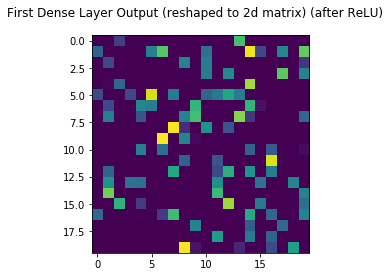

In [42]:
size = testing_y[2].numpy().shape[1]
dims = int(math.sqrt(size))
plt.suptitle("First Dense Layer Output (reshaped to 2d matrix) (after ReLU)")
plt.imshow(testing_y[2].numpy().squeeze().reshape(dims,dims))

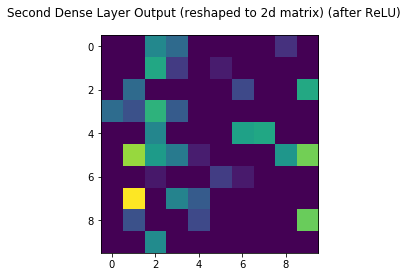

In [44]:
size = testing_y[3].numpy().shape[1]
dims = int(math.sqrt(size))
plt.suptitle("Second Dense Layer Output (reshaped to 2d matrix) (after ReLU)")
plt.imshow(testing_y[3].numpy().squeeze().reshape(dims,dims))

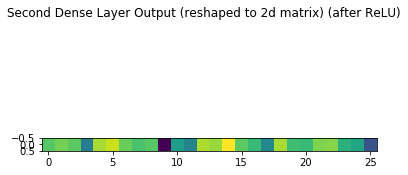

In [48]:
size = testing_y[4].numpy().shape[1]
plt.suptitle("Second Dense Layer Output (reshaped to 2d matrix) (after ReLU)")
plt.imshow(testing_y[4].numpy())

Text(0.5, 0.98, 'Train vs Test Loss - 10 Epochs')

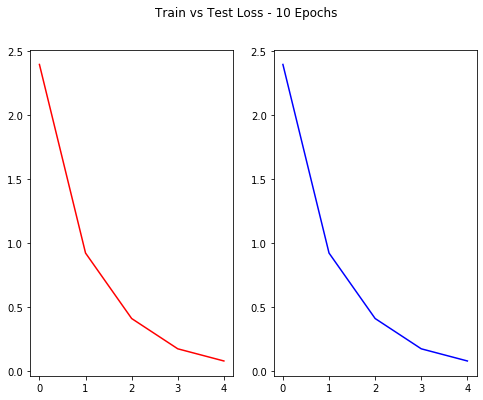

In [50]:
t = np.arange(0.,5.)
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(t,loss,'r')
plt.subplot(122)
plt.plot(t,t_loss,'b')
plt.suptitle("Train vs Test Loss - 10 Epochs")

Text(0.5, 0.98, 'Train vs Test Accuracy - 10 Epochs')

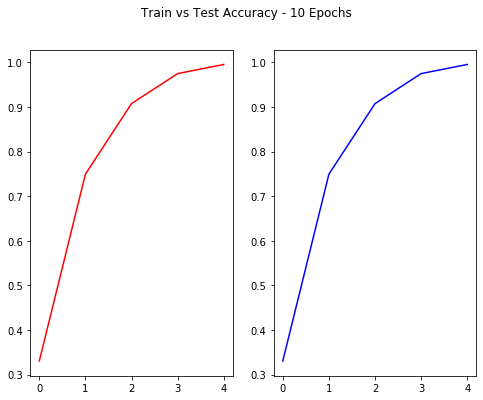

In [51]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(t,accuracy,'r')
plt.subplot(122)
plt.plot(t,t_accuracy,'b')
plt.suptitle("Train vs Test Accuracy - 10 Epochs")